In [ ]:
#!git clone https://github.com/iserranoz/deep_learning_up.git

Cloning into 'deep_learning_up'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 188.42 KiB | 7.85 MiB/s, done.


In [2]:
from torchvision import datasets
from torch.utils.data import random_split, ConcatDataset


data_train = datasets.STL10(root="data", split="train", download=True)
data_test = datasets.STL10(root="data", split="test", download=True)

extra_train_len = 4000
remaining_test_len = len(data_test) - extra_train_len

extra_train, data_test = random_split(data_test, [extra_train_len, remaining_test_len])

data_train = ConcatDataset([data_train, extra_train])


val_len = 2000
test_len = len(data_test) - val_len
data_val, data_test = random_split(data_test, [val_len, test_len])


print(f"Tamaño set de entrenamiento: {len(data_train)}")
print(f"Tamaño set de validación:    {len(data_val)}")
print(f"Tamaño set de test:          {len(data_test)}")

100%|██████████| 2.64G/2.64G [11:03<00:00, 3.98MB/s]


Tamaño set de entrenamiento: 9000
Tamaño set de validación:    2000
Tamaño set de test:          2000


In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, dataset, train=True):
        self.dataset = dataset

        if train:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)

        return image, label

In [4]:
dataset_train = ImageDataset(data_train)
dataset_test = ImageDataset(data_test)
dataset_val = ImageDataset(data_val)

print(f"Tamaño set de entrenamiento: {len(dataset_train)}")
print(f"Tamaño set de validación:    {len(dataset_val)}")
print(f"Tamaño set de test:        {len(dataset_test)}")

Tamaño set de entrenamiento: 9000
Tamaño set de validación:    2000
Tamaño set de test:        2000


In [5]:
idx = 200
img, lbl = dataset_train[idx]
print(f"Tipo de dato imagen: {type(img)}")
print(f"Máximo/mínimo imagen: {img.min()}/{img.max()}")
print(f"Tamaño imagen: {img.size()}")
print(f"Etiqueta imagen: {lbl}")

Tipo de dato imagen: <class 'torch.Tensor'>
Máximo/mínimo imagen: -1.0/1.0
Tamaño imagen: torch.Size([3, 96, 96])
Etiqueta imagen: 0


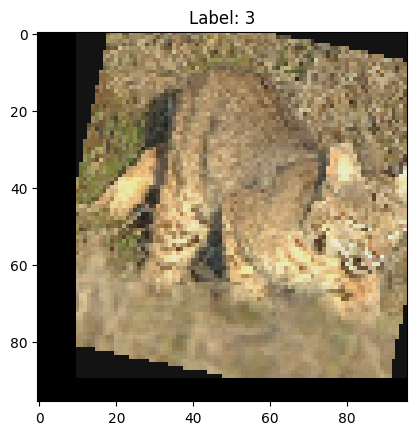

In [6]:
#Ejemplo de una imagen del dataset

import matplotlib.pyplot as plt
import numpy as np

idx = 4
img, lbl = dataset_train[idx]
img_np = img.numpy().transpose((1, 2, 0))
img_np = (img_np * 0.5) + 0.5

plt.imshow(img_np)
plt.title(f"Label: {lbl}")
plt.show()

In [9]:
#Importamos las librerías
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from tqdm import tqdm

# Hacemos uso de la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Configuramos los hiperparámetros
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Data loaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Usamos el modelo preeentrenado para 10 clases del dataset
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
model = model.to(device)

# Para la función de pérdida usaremos entropía cruzada y como opmtimizador usaremos Adam, tomar en cuenta que la tasa de aprendizaje definida previamente es de 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Empezamos el loop de entrenamiento

total_step = len(train_loader)

#Por cada época observaremos la pérdida
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                           (correct / total) * 100))



    # Para cada época miraremos también la validación del modelo con el fin de ver las mejoras entre épocas
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Preción del modelo: {} %'.format((correct / total) * 100))

# Finalmente haremos la validacón del modelo usando el dataset de prueba
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy del modelo {} test images: {} %'.format(total, (correct / total) * 100))


 72%|███████▏  | 101/141 [00:20<00:07,  5.23it/s]

Epoch [1/10], Step [100/141], Loss: 0.9753, Accuracy: 63.08%


100%|██████████| 141/141 [00:27<00:00,  5.06it/s]


Preción del modelo: 60.85 %


 72%|███████▏  | 101/141 [00:20<00:08,  4.82it/s]

Epoch [2/10], Step [100/141], Loss: 1.1540, Accuracy: 73.61%


100%|██████████| 141/141 [00:29<00:00,  4.86it/s]


Preción del modelo: 67.55 %


 72%|███████▏  | 101/141 [00:19<00:07,  5.36it/s]

Epoch [3/10], Step [100/141], Loss: 0.5920, Accuracy: 77.20%


100%|██████████| 141/141 [00:27<00:00,  5.08it/s]


Preción del modelo: 69.19999999999999 %


 72%|███████▏  | 101/141 [00:20<00:07,  5.37it/s]

Epoch [4/10], Step [100/141], Loss: 0.5241, Accuracy: 79.44%


100%|██████████| 141/141 [00:28<00:00,  5.01it/s]


Preción del modelo: 72.0 %


 72%|███████▏  | 101/141 [00:20<00:07,  5.30it/s]

Epoch [5/10], Step [100/141], Loss: 0.7190, Accuracy: 81.52%


100%|██████████| 141/141 [00:27<00:00,  5.12it/s]


Preción del modelo: 80.45 %


 71%|███████   | 100/141 [00:19<00:08,  5.03it/s]

Epoch [6/10], Step [100/141], Loss: 0.4823, Accuracy: 83.12%


100%|██████████| 141/141 [00:27<00:00,  5.12it/s]


Preción del modelo: 77.05 %


 72%|███████▏  | 101/141 [00:19<00:07,  5.33it/s]

Epoch [7/10], Step [100/141], Loss: 0.4433, Accuracy: 83.94%


100%|██████████| 141/141 [00:27<00:00,  5.06it/s]


Preción del modelo: 73.5 %


 72%|███████▏  | 101/141 [00:19<00:07,  5.33it/s]

Epoch [8/10], Step [100/141], Loss: 0.4235, Accuracy: 85.25%


100%|██████████| 141/141 [00:27<00:00,  5.10it/s]


Preción del modelo: 78.35 %


 71%|███████   | 100/141 [00:19<00:09,  4.44it/s]

Epoch [9/10], Step [100/141], Loss: 0.3743, Accuracy: 86.44%


100%|██████████| 141/141 [00:27<00:00,  5.14it/s]


Preción del modelo: 80.95 %


 72%|███████▏  | 101/141 [00:19<00:07,  5.36it/s]

Epoch [10/10], Step [100/141], Loss: 0.5479, Accuracy: 86.52%


100%|██████████| 141/141 [00:27<00:00,  5.10it/s]


Preción del modelo: 77.0 %
Accuracy del modelo 2000 test images: 76.8 %
